# Solution from Johannes Rieke and Alex Moore¶


In [2]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Exercise 1

## 1. Integration

In [3]:
from scipy.integrate import odeint

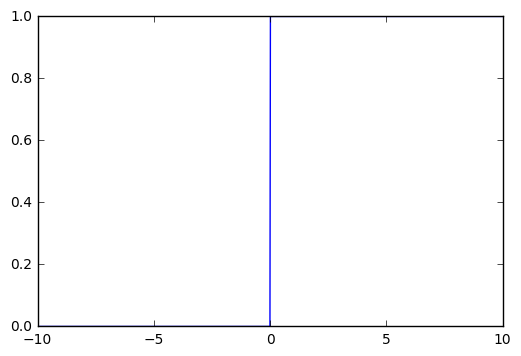

In [4]:
def step(x):
    return int(x >= 0)

x = np.linspace(-10, 10, 1000)
plt.plot(x, np.vectorize(step)(x))

In [5]:
def laing_chow(y, t, I1, I2, alpha=0.2, beta=0.4, phi=0.4, tau=20, g1=1, g2=1):
    u1, u2, a1, a2 = y
    du1 = -u1 + step(alpha * u1 * g1 - beta * u2 * g2 - a1 + I1)
    du2 = -u2 + step(alpha * u2 * g2 - beta * u1 * g1 - a2 + I2)
    da1 = 1 / tau * (-a1 + phi * step(alpha * u1 * g1 - beta * u2 * g2 - a1 + I1))
    da2 = 1 / tau * (-a2 + phi * step(alpha * u2 * g2 - beta * u1 * g1 - a2 + I2))
    return [du1, du2, da1, da2]

In [6]:
x0 = [1, 0, 0.1, 0.25]
t = np.linspace(0, 500, 10000)
I1 = 0.43
I2 = 0.5
u1, u2, a1, a2 = odeint(laing_chow, x0, t, args=(I1, I2)).T

In [7]:
def plot_results(u1, u2, a1, a2):
    plt.subplot(211)
    plt.plot(t, u1, label='u1')
    plt.plot(t, a1, label='a1')
    plt.grid()
    plt.xlim(0, 500)
    plt.legend()

    plt.subplot(212)
    plt.plot(t, u2, label='u2')
    plt.plot(t, a2, label='a2')
    plt.grid()
    plt.xlim(0, 500)
    plt.legend()
    plt.xlabel('t')

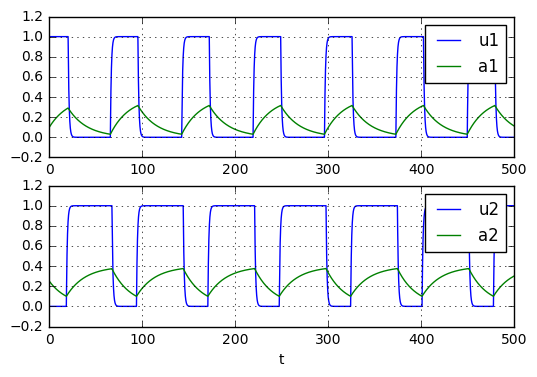

In [8]:
plot_results(u1, u2, a1, a2)


### 2. Dominance duration

In [9]:
def dominance_durations(x1, x2, t):
    durations = []
    start = None
    for X1, X2, T in zip(x1, x2, t):
        if start is None and X1 > X2:
            start = T
        elif start is not None and X1 < X2:
            durations.append(T - start)
            start = None
    if start is not None:  # population 1 active at the end of the simulation
        durations.append(t[-1] - start)
    return durations

In [10]:
dominance_durations(u1, u2, t)


[20.352035203520352,
 27.952795279527948,
 28.002800280027998,
 28.002800280027998,
 28.052805280528048,
 28.052805280528048,
 28.002800280027998]

Inserting the parameter values from above into eq. 9, one gets an analytical dominance duration of $T_1$ = 26.17. This is roughly in agreement with the simulated dominance durations (see above), but with a sligh deviation of ~2.


## 3. Oscillation stop


With the parameter values from above, $- \alpha + \beta + \phi$ = 0.6.


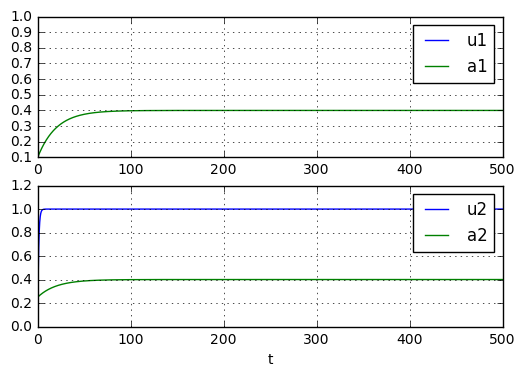

In [13]:
u1, u2, a1, a2 = odeint(laing_chow, x0, t, args=(0.8, 0.8)).T
plot_results(u1, u2, a1, a2)


The simulation confirms that for high inputs (here: 0.8), both populations are active and oscillation stops.


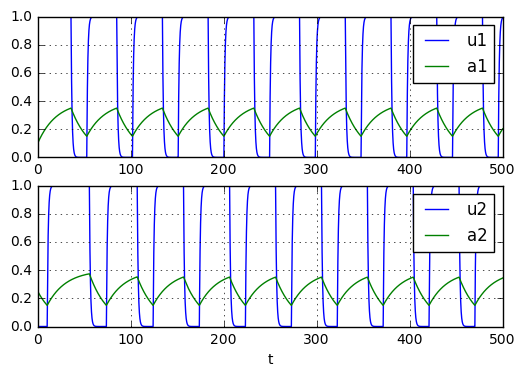

In [14]:
u1, u2, a1, a2 = odeint(laing_chow, x0, t, args=(0.55, 0.55)).T
plot_results(u1, u2, a1, a2)

In [16]:
dominance_durations(u1, u2, t)

[35.853585358535852,
 29.352935293529349,
 27.102710271027107,
 26.402640264026417,
 26.002600260025986,
 25.802580258025785,
 25.552555255525533,
 25.402540254025382,
 25.302530253025282,
 25.152515251525188]

For intermediate inputs (here: 0.55) the populations are inactive for shorter periods of time. Analytically, $T_1$ = 10.22. This deviates strongly from the simulated dominance durations (see above).


## Exercise 2

### 1. Problems with scipy.integrate.odeint

The Moereno-Bote model uses stochastic differential equations, therefore is not compatable with scipy.integrate.odeint

### 2. Euler-Maruyama 

In [127]:
def laing_chow(y, t, I1, I2, alpha=0.2, beta=0.4, phi=0.4, tau=20, g1=1, g2=1):
    u1, u2, a1, a2 = y
    du1 = -u1 + step(alpha * u1 * g1 - beta * u2 * g2 - a1 + I1)
    du2 = -u2 + step(alpha * u2 * g2 - beta * u1 * g1 - a2 + I2)
    da1 = 1 / tau * (-a1 + phi * step(alpha * u1 * g1 - beta * u2 * g2 - a1 + I1))
    da2 = 1 / tau * (-a2 + phi * step(alpha * u2 * g2 - beta * u1 * g1 - a2 + I2))
    return np.asarray([du1, du2, da1, da2])

In [128]:
def euler_maruyama(ffun, gfun, x_0, t_max, dt, *args,  **params):
    print(params)
    """
    Multidimensional Euler-Maruyama DE solver.    
    """
    x_0 = np.asarray(x_0)
    time = np.arange(0, t_max, dt)
    dx = np.zeros((x_0.size, time.size)).T
    dx[0,:] = x_0
    for t in range(time.size-1):
        W = np.random.normal()
        dx[t+1,:] = dx[t, :] + ffun(dx[t, :], t*dt, *args, **params) * dt + gfun(dx[t, :], t*dt, *args, **params) * np.sqrt(dt) * W
    return dx

{}


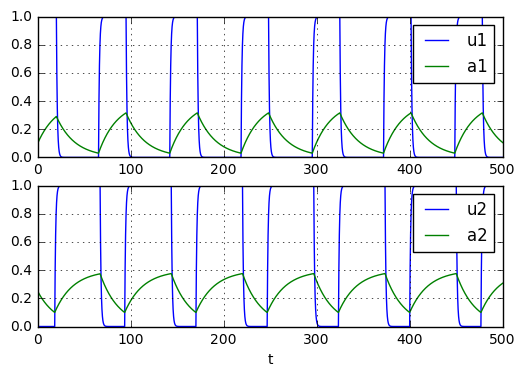

In [154]:
I1, I2 = 0.43, 0.5
g_fun = lambda *args: 0
y0 = [1.0, 0, 0.1, 0.25]
y1 = euler_maruyama(laing_chow, g_fun, y0, 500, 0.1, I1, I2)
t=np.linspace(0, 500, 5000)
plot_results(y4[:,0],y4[:,1],y4[:,2],y4[:,3])

Laing-Chow calculated using Euler-Maruyama

### 3. Stochastic DEs

{}


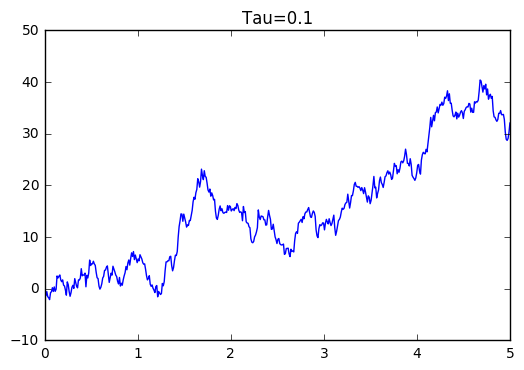

In [174]:
f_fun= lambda *args: 0
g_fun= lambda *args:(1/tau)
y0=0
tau=0.1
y2=euler_maruyama(f_fun, g_fun, y0, t_max=5, dt=0.01)
t=np.linspace(0,5,500)
plt.plot(t,y2)
plt.title("Tau=0.1")

{}


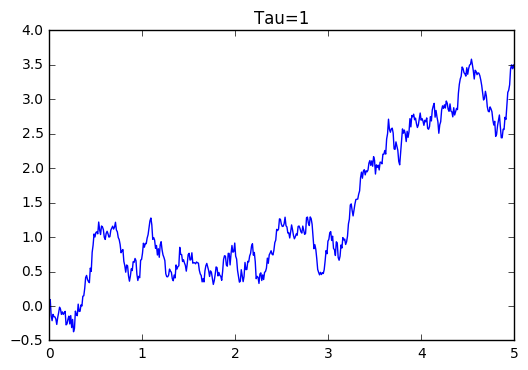

In [170]:
f_fun= lambda *args: 0
g_fun= lambda *args:(1/tau)
y0=0
tau=1
y3=euler_maruyama(f_fun, g_fun, y0, t_max=5, dt=0.01)
t=np.linspace(0,5,500)
plt.plot(t,y3)
plt.title("Tau=1")

{}


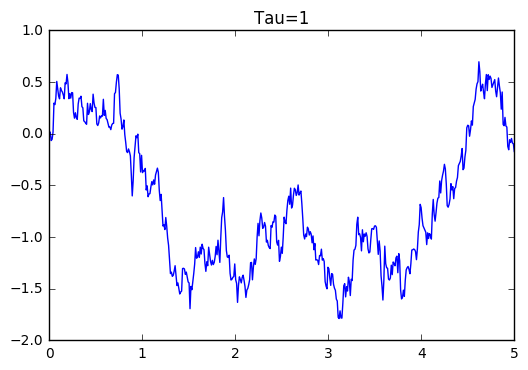

In [171]:
f_fun= lambda x, *args: (x/tau)
g_fun= lambda *args:(1/tau)
y0=0
tau=1
y4=euler_maruyama(f_fun, g_fun, y0, t_max=5, dt=0.01)
t=np.linspace(0,5,500)
plt.plot(t,y5)
plt.title("Tau=1")

The scale is very different between the three simulations, tau=0.1 produces a much greater range of values. 

In [175]:
# This probably requires some more explanation. 
#Including reference to Wiener processes and Ornstein-Uhlenbeck processes

### 4. Moreno-Bote simulation


In [179]:
def sigmoid(x, theta = 0.1, k = 0.05):
    return 1.0/(1+np.exp(-(x-theta)/k))

In [191]:
def f_moreno_bote(y, t, alpha = 0.75, beta= 0.5, gamma= 0.1, phi=0.5, tau= 0.01, tau_a= 2,
          tau_b= 2, tau_s= 0.1, eta= 0.5, g_a= 0.05, g_b= 0.05, f= sigmoid, sigma= 0.03):
    
    r_a, alpha_a,  r_b, alpha_b, n_a_d, n_b_d = y
    
    r_pool = max(0, phi*(r_a + r_b) + g_a + g_b)
    r_a_inh = (r_pool + eta * r_a)**2
    r_b_inh = (r_pool + eta * r_b)**2

    
    dydt = np.asarray([
         (-r_a + f(alpha * r_a - beta * r_a_inh + g_a - alpha_a + n_a_d))/tau,
         (-alpha_a + gamma * r_a)/tau_a,
         (-r_b + f(alpha * r_b - beta * r_b_inh + g_b - alpha_b + n_b_d))/tau,
         (-alpha_b + gamma * r_b)/tau_b,
         -n_a_d/tau_s,
         -n_b_d/tau_s])  

    return dydt




In [192]:
def g_moreno_bote(y, t, tau_s = 0.1, sigma = 0.03):
    _, _, _, _, n_a_s, n_b_s = y
    dydt = np.asarray([
            0.0,
            0.0,
            0.0,
            0.0,
            sigma * np.sqrt(2.0/tau_s) * np.random.normal(),
            sigma * np.sqrt(2.0/tau_s) * np.random.normal()
        ])
    return dydt

{}


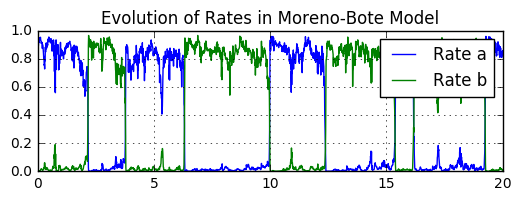

In [208]:
y0 = [1, 0, 0.01, 0.04, 0, 0]
t=np.linspace(0,20,2000)
y7 = euler_maruyama(f_moreno_bote, g_moreno_bote, y0, t_max = 20, dt=0.01)

plt.subplot(211)
plt.plot(t, y7[:,0], label='Rate a')
plt.plot(t,y7[:,2], label='Rate b')
plt.grid()
plt.xlim(0, 20)
plt.title("Evolution of Rates in Moreno-Bote Model")
plt.legend()

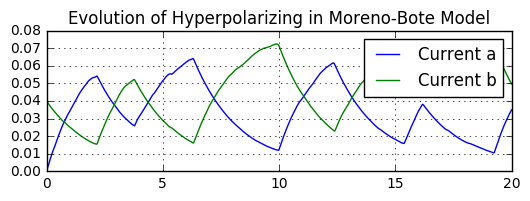

In [210]:
plt.subplot(211)
plt.plot(t, y7[:,1], label='Current a')
plt.plot(t,y7[:,3], label='Current b')
plt.grid()
plt.xlim(0, 20)
plt.title("Evolution of Hyperpolarizing in Moreno-Bote Model")
plt.legend()

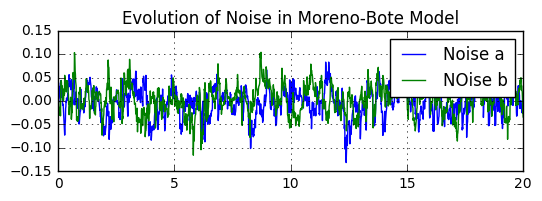

In [211]:
plt.subplot(211)
plt.plot(t, y7[:,4], label='Noise a')
plt.plot(t,y7[:,5], label='NOise b')
plt.grid()
plt.xlim(0, 20)
plt.title("Evolution of Noise in Moreno-Bote Model")
plt.legend()

### 5. Dominance Durations

In [212]:
y0 = [1, 0, 0.01, 0.04, 0, 0]
t=np.linspace(0,500,50000)
y8 = euler_maruyama(f_moreno_bote, g_moreno_bote, y0, t_max = 500, dt=0.01)

{}


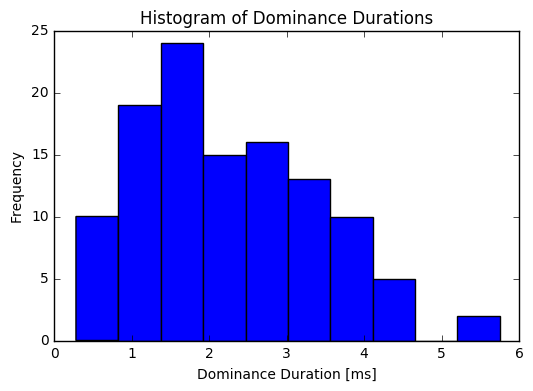

In [217]:
t=np.linspace(0,500,50000)
moreno_dominace=dominance_durations(y8[:,0], y8[:,2], t)
plt.hist(moreno_dominace)
plt.title("Histogram of Dominance Durations")
plt.xlabel("Dominance Duration [ms]")
plt.ylabel("Frequency")


In [218]:
np.mean(moreno_dominace)

2.2508344903740163

### 6. Effect of Gamma

In [219]:
# I could not manage to paramaterise the function appologies for the hack

def f_moreno_bote(y, t, alpha = 0.75, beta= 0.5, gamma= 0, phi=0.5, tau= 0.01, tau_a= 2,
          tau_b= 2, tau_s= 0.1, eta= 0.5, g_a= 0.05, g_b= 0.05, f= sigmoid, sigma= 0.03):
    
    r_a, alpha_a,  r_b, alpha_b, n_a_d, n_b_d = y
    
    r_pool = max(0, phi*(r_a + r_b) + g_a + g_b)
    r_a_inh = (r_pool + eta * r_a)**2
    r_b_inh = (r_pool + eta * r_b)**2

    
    dydt = np.asarray([
         (-r_a + f(alpha * r_a - beta * r_a_inh + g_a - alpha_a + n_a_d))/tau,
         (-alpha_a + gamma * r_a)/tau_a,
         (-r_b + f(alpha * r_b - beta * r_b_inh + g_b - alpha_b + n_b_d))/tau,
         (-alpha_b + gamma * r_b)/tau_b,
         -n_a_d/tau_s,
         -n_b_d/tau_s])  

    return dydt

{}


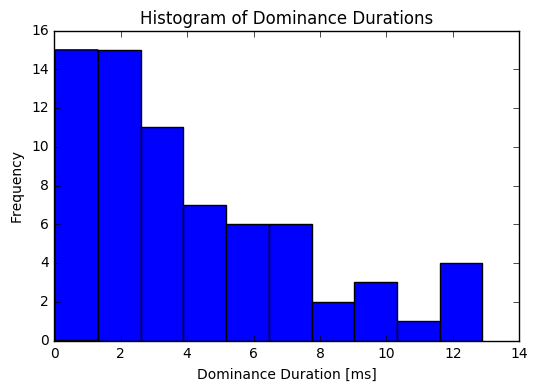

In [220]:
y9 = euler_maruyama(f_moreno_bote, g_moreno_bote, y0, t_max = 500, dt=0.01)
moreno_dominace=dominance_durations(y9[:,0], y9[:,2], t)
plt.hist(moreno_dominace)
plt.title("Histogram of Dominance Durations")
plt.xlabel("Dominance Duration [ms]")
plt.ylabel("Frequency")

In [221]:
np.mean(moreno_dominace)

4.1920838416768378

Reducing gamma to 0 increases the mean dominance duration. However, the modal Frequnecy is significantly lower, this increased mean is the result of a much broader spread of dominacne durations.